In [1]:
import os
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

# Set the paths to your datasets
monet_path = './monet_jpg'
photo_path = './photo_jpg'


# Function to load and preprocess images
def load_and_preprocess_images(path, size=(256, 256)):
    images = []
    for img_file in glob(os.path.join(path, "*.jpg")):
        img = load_img(img_file, target_size=size)  # Resize image
        img_array = img_to_array(img)  # Convert to numpy array
        img_array = (img_array / 127.5) - 1.0  # Normalize to [-1, 1]
        images.append(img_array)
    return np.array(images)

# Load datasets
monet_images = load_and_preprocess_images(monet_path)
photo_images = load_and_preprocess_images(photo_path)

# Convert numpy arrays to TensorFlow datasets
def create_tf_dataset(images, batch_size=16, buffer_size=1000):
    dataset = tf.data.Dataset.from_tensor_slices(images)
    dataset = dataset.shuffle(buffer_size).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Create datasets
batch_size = 16
monet_dataset = create_tf_dataset(monet_images, batch_size)
photo_dataset = create_tf_dataset(photo_images, batch_size)


In [2]:
# Generator Model
def build_generator():
    initializer = tf.random_normal_initializer(0., 0.02)
    inputs = layers.Input(shape=[256, 256, 3])

    # Downsampling
    down1 = layers.Conv2D(64, (4, 4), strides=2, padding='same', kernel_initializer=initializer, activation='relu')(inputs)
    down2 = layers.Conv2D(128, (4, 4), strides=2, padding='same', kernel_initializer=initializer, activation='relu')(down1)
    down3 = layers.Conv2D(256, (4, 4), strides=2, padding='same', kernel_initializer=initializer, activation='relu')(down2)
    
    # Bottleneck
    bottleneck = layers.Conv2D(512, (4, 4), strides=2, padding='same', kernel_initializer=initializer, activation='relu')(down3)

    # Upsampling
    up1 = layers.Conv2DTranspose(256, (4, 4), strides=2, padding='same', kernel_initializer=initializer, activation='relu')(bottleneck)
    up2 = layers.Conv2DTranspose(128, (4, 4), strides=2, padding='same', kernel_initializer=initializer, activation='relu')(up1)
    up3 = layers.Conv2DTranspose(64, (4, 4), strides=2, padding='same', kernel_initializer=initializer, activation='relu')(up2)
    
    # Output
    outputs = layers.Conv2DTranspose(3, (4, 4), strides=2, padding='same', kernel_initializer=initializer, activation='tanh')(up3)
    return Model(inputs, outputs)

# Discriminator Model (PatchGAN)
def build_discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    inputs = layers.Input(shape=[256, 256, 3])

    # Downsampling
    down1 = layers.Conv2D(64, (4, 4), strides=2, padding='same', kernel_initializer=initializer, activation='relu')(inputs)
    down2 = layers.Conv2D(128, (4, 4), strides=2, padding='same', kernel_initializer=initializer, activation='relu')(down1)
    down3 = layers.Conv2D(256, (4, 4), strides=2, padding='same', kernel_initializer=initializer, activation='relu')(down2)

    # Output layer
    outputs = layers.Conv2D(1, (4, 4), strides=1, padding='same', kernel_initializer=initializer)(down3)
    return Model(inputs, outputs)

# Instantiate models
generator_g = build_generator()  # Photo to Monet
generator_f = build_generator()  # Monet to Photo
discriminator_x = build_discriminator()  # Discriminator for Monet
discriminator_y = build_discriminator()  # Discriminator for Photo


In [12]:
# Loss Functions
def adversarial_loss(real, generated):
    return tf.reduce_mean(tf.square(real - generated))

def cycle_consistency_loss(real_image, cycled_image):
    return tf.reduce_mean(tf.abs(real_image - cycled_image))

def identity_loss(real_image, same_image):
    return tf.reduce_mean(tf.abs(real_image - same_image))

# Optimizers
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)


In [16]:
@tf.function
def train_step(real_x, real_y):
    with tf.GradientTape(persistent=True) as tape:
        # Generate fake images
        fake_y = generator_g(real_x, training=True)  # Photo to Monet
        fake_x = generator_f(real_y, training=True)  # Monet to Photo

        # Cycle consistency
        cycled_x = generator_f(fake_y, training=True)  # Monet back to Photo
        cycled_y = generator_g(fake_x, training=True)  # Photo back to Monet

        # Identity mappings
        same_x = generator_f(real_x, training=True)  # Photo to Photo
        same_y = generator_g(real_y, training=True)  # Monet to Monet

        # Discriminator predictions
        disc_real_x = discriminator_x(real_x, training=True)
        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)

        # Calculate losses
        gen_g_loss = adversarial_loss(tf.ones_like(disc_fake_y), disc_fake_y)
        gen_f_loss = adversarial_loss(tf.ones_like(disc_fake_x), disc_fake_x)

        cycle_loss = cycle_consistency_loss(real_x, cycled_x) + cycle_consistency_loss(real_y, cycled_y)
        id_loss = identity_loss(real_x, same_x) + identity_loss(real_y, same_y)

        total_gen_g_loss = gen_g_loss + cycle_loss * 10.0 + id_loss * 5.0
        total_gen_f_loss = gen_f_loss + cycle_loss * 10.0 + id_loss * 5.0

        disc_x_loss = adversarial_loss(tf.ones_like(disc_real_x), disc_real_x) + \
                      adversarial_loss(tf.zeros_like(disc_fake_x), disc_fake_x)
        disc_y_loss = adversarial_loss(tf.ones_like(disc_real_y), disc_real_y) + \
                      adversarial_loss(tf.zeros_like(disc_fake_y), disc_fake_y)

    # Calculate gradients and apply them
    generator_g_gradients = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)
    discriminator_x_gradients = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))
    generator_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))

    return {
        "gen_g_loss": total_gen_g_loss,
        "gen_f_loss": total_gen_f_loss,
        "disc_x_loss": disc_x_loss,
        "disc_y_loss": disc_y_loss,
    }


In [18]:
def train(dataset_x, dataset_y, epochs=20, save_interval=5):
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        for step, (real_x, real_y) in enumerate(zip(dataset_x, dataset_y)):
            losses = train_step(real_x, real_y)

        # Save models periodically
        if (epoch + 1) % save_interval == 0:
            generator_g.save(f'generator_g_epoch_{epoch + 1}.h5')
            generator_f.save(f'generator_f_epoch_{epoch + 1}.h5')
            discriminator_x.save(f'discriminator_x_epoch_{epoch + 1}.h5')
            discriminator_y.save(f'discriminator_y_epoch_{epoch + 1}.h5')

# Start Training
train(photo_dataset, monet_dataset, epochs=20, save_interval=5)


Epoch 1/20


ValueError: in user code:

    File "C:\Users\User\AppData\Local\Temp\ipykernel_12364\1498166668.py", line 42, in train_step  *
        generator_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))
    File "C:\Users\User\anaconda3\Lib\site-packages\keras\src\optimizers\base_optimizer.py", line 291, in apply_gradients  **
        self.apply(grads, trainable_variables)
    File "C:\Users\User\anaconda3\Lib\site-packages\keras\src\optimizers\base_optimizer.py", line 332, in apply
        self._check_variables_are_known(trainable_variables)
    File "C:\Users\User\anaconda3\Lib\site-packages\keras\src\optimizers\base_optimizer.py", line 237, in _check_variables_are_known
        raise ValueError(

    ValueError: Unknown variable: <KerasVariable shape=(4, 4, 3, 64), dtype=float32, path=conv2d_4/kernel>. This optimizer can only be called for the variables it was originally built with. When working with a new set of variables, you should recreate a new optimizer instance.


In [20]:
# Re-import necessary libraries
import os
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np
from glob import glob

# Define paths
monet_path = "path_to_monet_jpg"
photo_path = "path_to_photo_jpg"

# Data loading and preprocessing
def load_and_preprocess_images(path, size=(256, 256)):
    images = []
    for img_file in glob(os.path.join(path, "*.jpg")):
        img = load_img(img_file, target_size=size)
        img_array = img_to_array(img)
        img_array = (img_array / 127.5) - 1.0
        images.append(img_array)
    return np.array(images)

# Set the paths to your datasets
monet_path = './monet_jpg'
photo_path = './photo_jpg'

def create_tf_dataset(images, batch_size=16, buffer_size=1000):
    dataset = tf.data.Dataset.from_tensor_slices(images)
    dataset = dataset.shuffle(buffer_size).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

batch_size = 16
monet_dataset = create_tf_dataset(monet_images, batch_size)
photo_dataset = create_tf_dataset(photo_images, batch_size)

# Define generator model
def build_generator():
    initializer = tf.random_normal_initializer(0., 0.02)
    inputs = layers.Input(shape=[256, 256, 3])
    down1 = layers.Conv2D(64, (4, 4), strides=2, padding='same', kernel_initializer=initializer, activation='relu')(inputs)
    down2 = layers.Conv2D(128, (4, 4), strides=2, padding='same', kernel_initializer=initializer, activation='relu')(down1)
    bottleneck = layers.Conv2D(256, (4, 4), strides=2, padding='same', kernel_initializer=initializer, activation='relu')(down2)
    up1 = layers.Conv2DTranspose(128, (4, 4), strides=2, padding='same', kernel_initializer=initializer, activation='relu')(bottleneck)
    up2 = layers.Conv2DTranspose(64, (4, 4), strides=2, padding='same', kernel_initializer=initializer, activation='relu')(up1)
    outputs = layers.Conv2DTranspose(3, (4, 4), strides=2, padding='same', kernel_initializer=initializer, activation='tanh')(up2)
    return Model(inputs, outputs)

# Define discriminator model
def build_discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    inputs = layers.Input(shape=[256, 256, 3])
    down1 = layers.Conv2D(64, (4, 4), strides=2, padding='same', kernel_initializer=initializer, activation='relu')(inputs)
    down2 = layers.Conv2D(128, (4, 4), strides=2, padding='same', kernel_initializer=initializer, activation='relu')(down1)
    outputs = layers.Conv2D(1, (4, 4), strides=1, padding='same', kernel_initializer=initializer)(down2)
    return Model(inputs, outputs)

# Instantiate models
generator_g = build_generator()
generator_f = build_generator()
discriminator_x = build_discriminator()
discriminator_y = build_discriminator()

# Define losses and optimizers
def adversarial_loss(real, generated):
    return tf.reduce_mean(tf.square(real - generated))

def cycle_consistency_loss(real_image, cycled_image):
    return tf.reduce_mean(tf.abs(real_image - cycled_image))

def identity_loss(real_image, same_image):
    return tf.reduce_mean(tf.abs(real_image - same_image))

# Reinitialize optimizers
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)

# Define training step
@tf.function
def train_step(real_x, real_y):
    with tf.GradientTape(persistent=True) as tape:
        fake_y = generator_g(real_x, training=True)
        fake_x = generator_f(real_y, training=True)
        cycled_x = generator_f(fake_y, training=True)
        cycled_y = generator_g(fake_x, training=True)
        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)
        disc_real_x = discriminator_x(real_x, training=True)
        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)

        gen_g_loss = adversarial_loss(tf.ones_like(disc_fake_y), disc_fake_y)
        gen_f_loss = adversarial_loss(tf.ones_like(disc_fake_x), disc_fake_x)
        cycle_loss = cycle_consistency_loss(real_x, cycled_x) + cycle_consistency_loss(real_y, cycled_y)
        id_loss = identity_loss(real_x, same_x) + identity_loss(real_y, same_y)
        total_gen_g_loss = gen_g_loss + cycle_loss * 10.0 + id_loss * 5.0
        total_gen_f_loss = gen_f_loss + cycle_loss * 10.0 + id_loss * 5.0
        disc_x_loss = adversarial_loss(tf.ones_like(disc_real_x), disc_real_x) + \
                      adversarial_loss(tf.zeros_like(disc_fake_x), disc_fake_x)
        disc_y_loss = adversarial_loss(tf.ones_like(disc_real_y), disc_real_y) + \
                      adversarial_loss(tf.zeros_like(disc_fake_y), disc_fake_y)

    generator_g_gradients = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)
    discriminator_x_gradients = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))
    generator_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))

    return {
        "gen_g_loss": total_gen_g_loss,
        "gen_f_loss": total_gen_f_loss,
        "disc_x_loss": disc_x_loss,
        "disc_y_loss": disc_y_loss,
    }

# Training loop
def train(dataset_x, dataset_y, epochs=20, save_interval=5):
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        for step, (real_x, real_y) in enumerate(zip(dataset_x, dataset_y)):
            train_step(real_x, real_y)
        if (epoch + 1) % save_interval == 0:
            generator_g.save(f'generator_g_epoch_{epoch + 1}.h5')
            generator_f.save(f'generator_f_epoch_{epoch + 1}.h5')
            discriminator_x.save(f'discriminator_x_epoch_{epoch + 1}.h5')
            discriminator_y.save(f'discriminator_y_epoch_{epoch + 1}.h5')

# Start training
train(photo_dataset, monet_dataset, epochs=20, save_interval=5)


Epoch 1/20


ValueError: in user code:

    File "C:\Users\User\AppData\Local\Temp\ipykernel_12364\676090658.py", line 107, in train_step  *
        generator_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))
    File "C:\Users\User\anaconda3\Lib\site-packages\keras\src\optimizers\base_optimizer.py", line 291, in apply_gradients  **
        self.apply(grads, trainable_variables)
    File "C:\Users\User\anaconda3\Lib\site-packages\keras\src\optimizers\base_optimizer.py", line 332, in apply
        self._check_variables_are_known(trainable_variables)
    File "C:\Users\User\anaconda3\Lib\site-packages\keras\src\optimizers\base_optimizer.py", line 237, in _check_variables_are_known
        raise ValueError(

    ValueError: Unknown variable: <KerasVariable shape=(4, 4, 3, 64), dtype=float32, path=conv2d_19/kernel>. This optimizer can only be called for the variables it was originally built with. When working with a new set of variables, you should recreate a new optimizer instance.


In [22]:
import os
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np
from glob import glob


# Set the paths to your datasets
monet_path = './monet_jpg'
photo_path = './photo_jpg'

# Load and preprocess images
def load_and_preprocess_images(path, size=(256, 256)):
    images = []
    for img_file in glob(os.path.join(path, "*.jpg")):
        img = load_img(img_file, target_size=size)
        img_array = img_to_array(img)
        img_array = (img_array / 127.5) - 1.0
        images.append(img_array)
    return np.array(images)

# Load datasets
monet_images = load_and_preprocess_images(monet_path)
photo_images = load_and_preprocess_images(photo_path)

def create_tf_dataset(images, batch_size=16, buffer_size=1000):
    dataset = tf.data.Dataset.from_tensor_slices(images)
    dataset = dataset.shuffle(buffer_size).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

batch_size = 16
monet_dataset = create_tf_dataset(monet_images, batch_size)
photo_dataset = create_tf_dataset(photo_images, batch_size)

# Generator model
def build_generator():
    initializer = tf.random_normal_initializer(0., 0.02)
    inputs = layers.Input(shape=[256, 256, 3])
    down1 = layers.Conv2D(64, (4, 4), strides=2, padding='same', kernel_initializer=initializer, activation='relu')(inputs)
    down2 = layers.Conv2D(128, (4, 4), strides=2, padding='same', kernel_initializer=initializer, activation='relu')(down1)
    bottleneck = layers.Conv2D(256, (4, 4), strides=2, padding='same', kernel_initializer=initializer, activation='relu')(down2)
    up1 = layers.Conv2DTranspose(128, (4, 4), strides=2, padding='same', kernel_initializer=initializer, activation='relu')(bottleneck)
    up2 = layers.Conv2DTranspose(64, (4, 4), strides=2, padding='same', kernel_initializer=initializer, activation='relu')(up1)
    outputs = layers.Conv2DTranspose(3, (4, 4), strides=2, padding='same', kernel_initializer=initializer, activation='tanh')(up2)
    return Model(inputs, outputs)

# Discriminator model
def build_discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    inputs = layers.Input(shape=[256, 256, 3])
    down1 = layers.Conv2D(64, (4, 4), strides=2, padding='same', kernel_initializer=initializer, activation='relu')(inputs)
    down2 = layers.Conv2D(128, (4, 4), strides=2, padding='same', kernel_initializer=initializer, activation='relu')(down1)
    outputs = layers.Conv2D(1, (4, 4), strides=1, padding='same', kernel_initializer=initializer)(down2)
    return Model(inputs, outputs)

# Instantiate models
generator_g = build_generator()
generator_f = build_generator()
discriminator_x = build_discriminator()
discriminator_y = build_discriminator()

# Loss functions
def adversarial_loss(real, generated):
    return tf.reduce_mean(tf.square(real - generated))

def cycle_consistency_loss(real_image, cycled_image):
    return tf.reduce_mean(tf.abs(real_image - cycled_image))

def identity_loss(real_image, same_image):
    return tf.reduce_mean(tf.abs(real_image - same_image))

# Training step
@tf.function
def train_step(real_x, real_y, generator_optimizer, discriminator_optimizer):
    with tf.GradientTape(persistent=True) as tape:
        fake_y = generator_g(real_x, training=True)
        fake_x = generator_f(real_y, training=True)
        cycled_x = generator_f(fake_y, training=True)
        cycled_y = generator_g(fake_x, training=True)
        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)
        disc_real_x = discriminator_x(real_x, training=True)
        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)

        gen_g_loss = adversarial_loss(tf.ones_like(disc_fake_y), disc_fake_y)
        gen_f_loss = adversarial_loss(tf.ones_like(disc_fake_x), disc_fake_x)
        cycle_loss = cycle_consistency_loss(real_x, cycled_x) + cycle_consistency_loss(real_y, cycled_y)
        id_loss = identity_loss(real_x, same_x) + identity_loss(real_y, same_y)
        total_gen_g_loss = gen_g_loss + cycle_loss * 10.0 + id_loss * 5.0
        total_gen_f_loss = gen_f_loss + cycle_loss * 10.0 + id_loss * 5.0
        disc_x_loss = adversarial_loss(tf.ones_like(disc_real_x), disc_real_x) + \
                      adversarial_loss(tf.zeros_like(disc_fake_x), disc_fake_x)
        disc_y_loss = adversarial_loss(tf.ones_like(disc_real_y), disc_real_y) + \
                      adversarial_loss(tf.zeros_like(disc_fake_y), disc_fake_y)

    generator_g_gradients = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)
    discriminator_x_gradients = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))
    generator_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))

    return {
        "gen_g_loss": total_gen_g_loss,
        "gen_f_loss": total_gen_f_loss,
        "disc_x_loss": disc_x_loss,
        "disc_y_loss": disc_y_loss,
    }

# Training loop
def train(dataset_x, dataset_y, epochs=20, save_interval=5):
    generator_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)
    discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        for step, (real_x, real_y) in enumerate(zip(dataset_x, dataset_y)):
            train_step(real_x, real_y, generator_optimizer, discriminator_optimizer)
        if (epoch + 1) % save_interval == 0:
            generator_g.save(f'generator_g_epoch_{epoch + 1}.h5')
            generator_f.save(f'generator_f_epoch_{epoch + 1}.h5')
            discriminator_x.save(f'discriminator_x_epoch_{epoch + 1}.h5')
            discriminator_y.save(f'discriminator_y_epoch_{epoch + 1}.h5')

# Start training
train(photo_dataset, monet_dataset, epochs=20, save_interval=5)


Epoch 1/20


ValueError: in user code:

    File "C:\Users\User\AppData\Local\Temp\ipykernel_12364\3591322524.py", line 103, in train_step  *
        generator_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))
    File "C:\Users\User\anaconda3\Lib\site-packages\keras\src\optimizers\base_optimizer.py", line 291, in apply_gradients  **
        self.apply(grads, trainable_variables)
    File "C:\Users\User\anaconda3\Lib\site-packages\keras\src\optimizers\base_optimizer.py", line 332, in apply
        self._check_variables_are_known(trainable_variables)
    File "C:\Users\User\anaconda3\Lib\site-packages\keras\src\optimizers\base_optimizer.py", line 237, in _check_variables_are_known
        raise ValueError(

    ValueError: Unknown variable: <KerasVariable shape=(4, 4, 3, 64), dtype=float32, path=conv2d_31/kernel>. This optimizer can only be called for the variables it was originally built with. When working with a new set of variables, you should recreate a new optimizer instance.


In [24]:
import os
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np
from glob import glob

# Set the paths to your datasets
monet_path = './monet_jpg'
photo_path = './photo_jpg'

# Load and preprocess images
def load_and_preprocess_images(path, size=(256, 256)):
    images = []
    for img_file in glob(os.path.join(path, "*.jpg")):
        img = load_img(img_file, target_size=size)
        img_array = img_to_array(img)
        img_array = (img_array / 127.5) - 1.0
        images.append(img_array)
    return np.array(images)

# Load datasets
monet_images = load_and_preprocess_images(monet_path)
photo_images = load_and_preprocess_images(photo_path)

def create_tf_dataset(images, batch_size=16, buffer_size=1000):
    dataset = tf.data.Dataset.from_tensor_slices(images)
    dataset = dataset.shuffle(buffer_size).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

batch_size = 16
monet_dataset = create_tf_dataset(monet_images, batch_size)
photo_dataset = create_tf_dataset(photo_images, batch_size)

# Generator model
def build_generator():
    initializer = tf.random_normal_initializer(0., 0.02)
    inputs = layers.Input(shape=[256, 256, 3])
    down1 = layers.Conv2D(64, (4, 4), strides=2, padding='same', kernel_initializer=initializer, activation='relu')(inputs)
    down2 = layers.Conv2D(128, (4, 4), strides=2, padding='same', kernel_initializer=initializer, activation='relu')(down1)
    bottleneck = layers.Conv2D(256, (4, 4), strides=2, padding='same', kernel_initializer=initializer, activation='relu')(down2)
    up1 = layers.Conv2DTranspose(128, (4, 4), strides=2, padding='same', kernel_initializer=initializer, activation='relu')(bottleneck)
    up2 = layers.Conv2DTranspose(64, (4, 4), strides=2, padding='same', kernel_initializer=initializer, activation='relu')(up1)
    outputs = layers.Conv2DTranspose(3, (4, 4), strides=2, padding='same', kernel_initializer=initializer, activation='tanh')(up2)
    return Model(inputs, outputs)

# Discriminator model
def build_discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    inputs = layers.Input(shape=[256, 256, 3])
    down1 = layers.Conv2D(64, (4, 4), strides=2, padding='same', kernel_initializer=initializer, activation='relu')(inputs)
    down2 = layers.Conv2D(128, (4, 4), strides=2, padding='same', kernel_initializer=initializer, activation='relu')(down1)
    outputs = layers.Conv2D(1, (4, 4), strides=1, padding='same', kernel_initializer=initializer)(down2)
    return Model(inputs, outputs)

# Instantiate models
generator_g = build_generator()
generator_f = build_generator()
discriminator_x = build_discriminator()
discriminator_y = build_discriminator()

# Loss functions
def adversarial_loss(real, generated):
    return tf.reduce_mean(tf.square(real - generated))

def cycle_consistency_loss(real_image, cycled_image):
    return tf.reduce_mean(tf.abs(real_image - cycled_image))

def identity_loss(real_image, same_image):
    return tf.reduce_mean(tf.abs(real_image - same_image))

# Training step
@tf.function
def train_step(real_x, real_y, generator_g, generator_f, discriminator_x, discriminator_y, generator_optimizer, discriminator_optimizer):
    with tf.GradientTape(persistent=True) as tape:
        fake_y = generator_g(real_x, training=True)
        fake_x = generator_f(real_y, training=True)
        cycled_x = generator_f(fake_y, training=True)
        cycled_y = generator_g(fake_x, training=True)
        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)
        disc_real_x = discriminator_x(real_x, training=True)
        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)

        gen_g_loss = adversarial_loss(tf.ones_like(disc_fake_y), disc_fake_y)
        gen_f_loss = adversarial_loss(tf.ones_like(disc_fake_x), disc_fake_x)
        cycle_loss = cycle_consistency_loss(real_x, cycled_x) + cycle_consistency_loss(real_y, cycled_y)
        id_loss = identity_loss(real_x, same_x) + identity_loss(real_y, same_y)
        total_gen_g_loss = gen_g_loss + cycle_loss * 10.0 + id_loss * 5.0
        total_gen_f_loss = gen_f_loss + cycle_loss * 10.0 + id_loss * 5.0
        disc_x_loss = adversarial_loss(tf.ones_like(disc_real_x), disc_real_x) + \
                      adversarial_loss(tf.zeros_like(disc_fake_x), disc_fake_x)
        disc_y_loss = adversarial_loss(tf.ones_like(disc_real_y), disc_real_y) + \
                      adversarial_loss(tf.zeros_like(disc_fake_y), disc_fake_y)

    generator_g_gradients = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)
    discriminator_x_gradients = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))
    generator_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))

    return {
        "gen_g_loss": total_gen_g_loss,
        "gen_f_loss": total_gen_f_loss,
        "disc_x_loss": disc_x_loss,
        "disc_y_loss": disc_y_loss,
    }

# Training loop
def train(dataset_x, dataset_y, epochs=20, save_interval=5):
    generator_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)
    discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)
    
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        for step, (real_x, real_y) in enumerate(zip(dataset_x, dataset_y)):
            losses = train_step(real_x, real_y, generator_g, generator_f, discriminator_x, discriminator_y, generator_optimizer, discriminator_optimizer)
        
        if (epoch + 1) % save_interval == 0:
            generator_g.save(f'generator_g_epoch_{epoch + 1}.h5')
            generator_f.save(f'generator_f_epoch_{epoch + 1}.h5')
            discriminator_x.save(f'discriminator_x_epoch_{epoch + 1}.h5')
            discriminator_y.save(f'discriminator_y_epoch_{epoch + 1}.h5')

# Start training
train(photo_dataset, monet_dataset, epochs=20, save_interval=5)

MemoryError: Unable to allocate 3.12 GiB for an array with shape (4265, 256, 256, 3) and data type float32

In [30]:
import os
import tensorflow as tf
from tensorflow.keras import layers, Model
from glob import glob

# Set the paths to your datasets
monet_path = './monet_jpg'
photo_path = './photo_jpg'

def load_and_preprocess_image(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [256, 256])
    img = tf.cast(img, tf.float32)
    img = (img / 127.5) - 1.0
    return img

def create_dataset(file_pattern, batch_size=16, buffer_size=1000):
    file_list = tf.data.Dataset.list_files(file_pattern)
    dataset = file_list.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(buffer_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# Create datasets
monet_dataset = create_dataset(os.path.join(monet_path, '*.jpg'))
photo_dataset = create_dataset(os.path.join(photo_path, '*.jpg'))

# Generator model
def build_generator():
    initializer = tf.random_normal_initializer(0., 0.02)
    inputs = layers.Input(shape=[256, 256, 3])
    down1 = layers.Conv2D(64, (4, 4), strides=2, padding='same', kernel_initializer=initializer, activation='relu')(inputs)
    down2 = layers.Conv2D(128, (4, 4), strides=2, padding='same', kernel_initializer=initializer, activation='relu')(down1)
    bottleneck = layers.Conv2D(256, (4, 4), strides=2, padding='same', kernel_initializer=initializer, activation='relu')(down2)
    up1 = layers.Conv2DTranspose(128, (4, 4), strides=2, padding='same', kernel_initializer=initializer, activation='relu')(bottleneck)
    up2 = layers.Conv2DTranspose(64, (4, 4), strides=2, padding='same', kernel_initializer=initializer, activation='relu')(up1)
    outputs = layers.Conv2DTranspose(3, (4, 4), strides=2, padding='same', kernel_initializer=initializer, activation='tanh')(up2)
    return Model(inputs, outputs)

# Discriminator model
def build_discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    inputs = layers.Input(shape=[256, 256, 3])
    down1 = layers.Conv2D(64, (4, 4), strides=2, padding='same', kernel_initializer=initializer, activation='relu')(inputs)
    down2 = layers.Conv2D(128, (4, 4), strides=2, padding='same', kernel_initializer=initializer, activation='relu')(down1)
    outputs = layers.Conv2D(1, (4, 4), strides=1, padding='same', kernel_initializer=initializer)(down2)
    return Model(inputs, outputs)

# Instantiate models
generator_g = build_generator()
generator_f = build_generator()
discriminator_x = build_discriminator()
discriminator_y = build_discriminator()

# Create optimizers
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)

# Initialize optimizers with model variables
dummy_input = tf.zeros([1, 256, 256, 3])
_ = generator_g(dummy_input)
_ = generator_f(dummy_input)
_ = discriminator_x(dummy_input)
_ = discriminator_y(dummy_input)

generator_optimizer.build(generator_g.trainable_variables + generator_f.trainable_variables)
discriminator_optimizer.build(discriminator_x.trainable_variables + discriminator_y.trainable_variables)

# Loss functions
def adversarial_loss(real, generated):
    return tf.reduce_mean(tf.square(real - generated))

def cycle_consistency_loss(real_image, cycled_image):
    return tf.reduce_mean(tf.abs(real_image - cycled_image))

def identity_loss(real_image, same_image):
    return tf.reduce_mean(tf.abs(real_image - same_image))

# Training step
@tf.function
def train_step(real_x, real_y):
    with tf.GradientTape(persistent=True) as tape:
        fake_y = generator_g(real_x, training=True)
        fake_x = generator_f(real_y, training=True)
        cycled_x = generator_f(fake_y, training=True)
        cycled_y = generator_g(fake_x, training=True)
        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)
        disc_real_x = discriminator_x(real_x, training=True)
        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)

        gen_g_loss = adversarial_loss(tf.ones_like(disc_fake_y), disc_fake_y)
        gen_f_loss = adversarial_loss(tf.ones_like(disc_fake_x), disc_fake_x)
        cycle_loss = cycle_consistency_loss(real_x, cycled_x) + cycle_consistency_loss(real_y, cycled_y)
        id_loss = identity_loss(real_x, same_x) + identity_loss(real_y, same_y)
        total_gen_g_loss = gen_g_loss + cycle_loss * 10.0 + id_loss * 5.0
        total_gen_f_loss = gen_f_loss + cycle_loss * 10.0 + id_loss * 5.0
        disc_x_loss = adversarial_loss(tf.ones_like(disc_real_x), disc_real_x) + \
                      adversarial_loss(tf.zeros_like(disc_fake_x), disc_fake_x)
        disc_y_loss = adversarial_loss(tf.ones_like(disc_real_y), disc_real_y) + \
                      adversarial_loss(tf.zeros_like(disc_fake_y), disc_fake_y)

    generator_g_gradients = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)
    discriminator_x_gradients = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))
    generator_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))

    return {
        "gen_g_loss": total_gen_g_loss,
        "gen_f_loss": total_gen_f_loss,
        "disc_x_loss": disc_x_loss,
        "disc_y_loss": disc_y_loss,
    }

# Training loop
def train(monet_dataset, photo_dataset, epochs=20, save_interval=5):
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        for real_x, real_y in tf.data.Dataset.zip((photo_dataset, monet_dataset)):
            losses = train_step(real_x, real_y)
        
        if (epoch + 1) % save_interval == 0:
            generator_g.save(f'generator_g_epoch_{epoch + 1}.h5')
            generator_f.save(f'generator_f_epoch_{epoch + 1}.h5')
            discriminator_x.save(f'discriminator_x_epoch_{epoch + 1}.h5')
            discriminator_y.save(f'discriminator_y_epoch_{epoch + 1}.h5')

# Start training
train(monet_dataset, photo_dataset, epochs=20, save_interval=5)

Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20


Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20


Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20


Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20


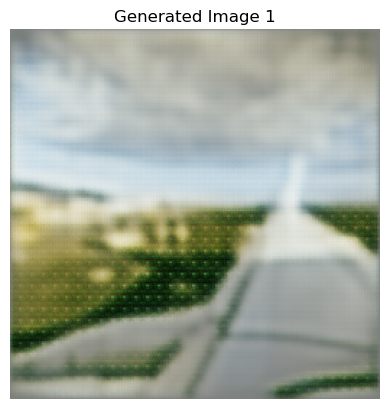

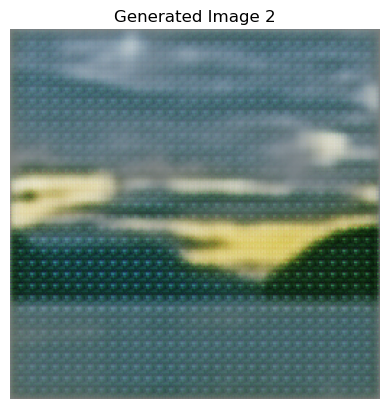

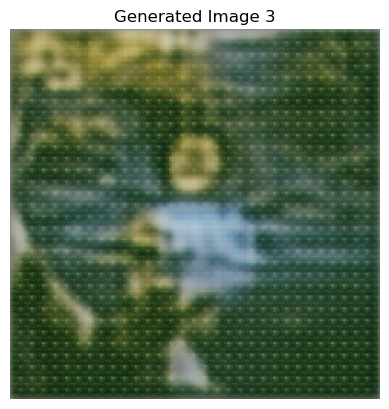

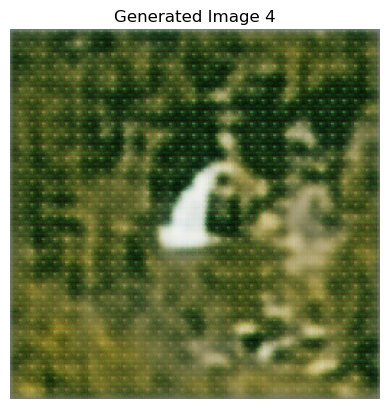

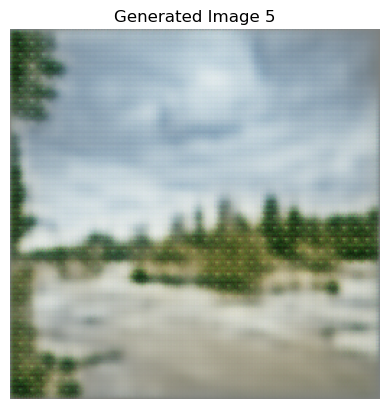

In [59]:
import matplotlib.pyplot as plt

# Generate and visualize Monet-style images
def generate_and_save_images(generator, dataset, output_dir='generated_images', num_images=5):
    os.makedirs(output_dir, exist_ok=True)
    for i, image in enumerate(dataset.take(num_images)):
        # Generate image
        generated_image = generator(image, training=False)
        generated_image = ((generated_image[0] + 1.0) * 127.5).numpy().astype("uint8")

        # Save generated image
        save_path = os.path.join(output_dir, f'generated_image_{i + 1}.jpg')
        tf.keras.preprocessing.image.save_img(save_path, generated_image)

        # Display image
        plt.figure()
        plt.imshow(generated_image)
        plt.axis("off")
        plt.title(f"Generated Image {i + 1}")
        plt.show()

# Generate and save Monet-style images
generate_and_save_images(generator_g, photo_dataset, output_dir="monet_results")


In [51]:
def batch_inference(generator, input_path, output_path):
    os.makedirs(output_path, exist_ok=True)
    file_list = glob(os.path.join(input_path, "*.jpg"))
    
    for i, file_path in enumerate(file_list):
        img = load_and_preprocess_image(file_path)
        img = tf.expand_dims(img, axis=0)  # Add batch dimension
        generated_img = generator(img, training=False)[0]
        generated_img = ((generated_img + 1.0) * 127.5).numpy().astype("uint8")
        
        save_path = os.path.join(output_path, f"monet_style_{i + 1}.jpg")
        tf.keras.preprocessing.image.save_img(save_path, generated_img)
        print(f"Saved: {save_path}")

# Example Usage
batch_inference(generator_g, input_path="./test_photos", output_path="./monet_style_outputs")


In [61]:
import matplotlib.pyplot as plt

# Generate and visualize Monet-style images with side-by-side comparison
def generate_and_save_comparison(generator, dataset, output_dir='generated_images', num_images=5):
    os.makedirs(output_dir, exist_ok=True)
    for i, image in enumerate(dataset.take(num_images)):
        # Prepare original image
        original_image = ((image + 1.0) * 127.5).numpy().astype("uint8")
        
        # Generate Monet-style image
        generated_image = generator(tf.expand_dims(image, axis=0), training=False)[0]
        generated_image = ((generated_image + 1.0) * 127.5).numpy().astype("uint8")
        
        # Save the generated image
        save_path = os.path.join(output_dir, f'generated_image_{i + 1}.jpg')
        tf.keras.preprocessing.image.save_img(save_path, generated_image)
        
        # Display side-by-side comparison
        plt.figure(figsize=(10, 5))
        
        # Original Image
        plt.subplot(1, 2, 1)
        plt.imshow(original_image)
        plt.axis("off")
        plt.title("Original Photo")
        
        # Generated Image
        plt.subplot(1, 2, 2)
        plt.imshow(generated_image)
        plt.axis("off")
        plt.title(f"Monet-Style Image {i + 1}")
        
        # Show plot
        plt.show()

# Generate and save comparison images
generate_and_save_comparison(generator_g, photo_dataset, output_dir="monet_results")


ValueError: Input 0 of layer "functional_16" is incompatible with the layer: expected shape=(None, 256, 256, 3), found shape=(1, 16, 256, 256, 3)

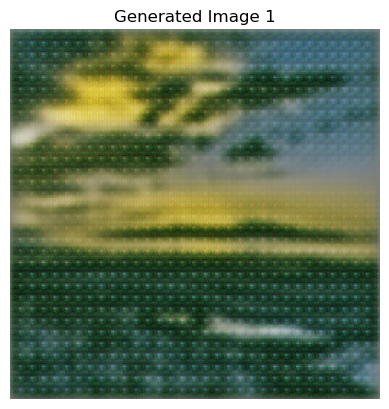

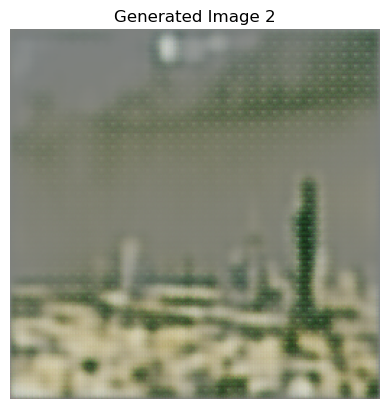

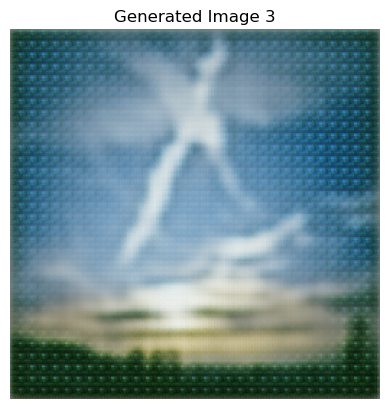

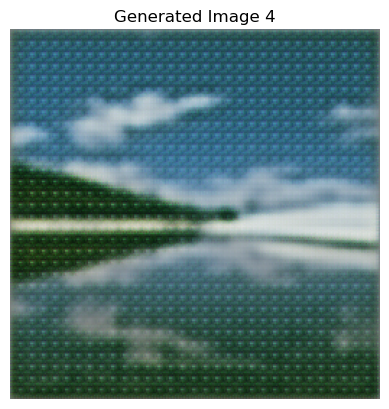

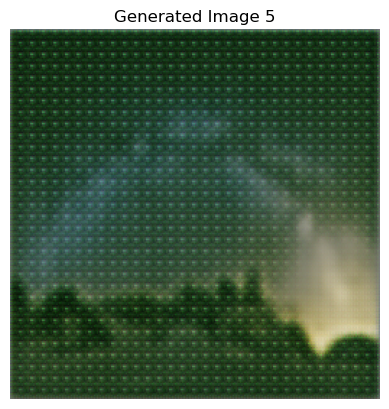

In [56]:
import matplotlib.pyplot as plt

# Generate and visualize Monet-style images
def generate_and_save_images(generator, dataset, output_dir='generated_images', num_images=5):
    os.makedirs(output_dir, exist_ok=True)  # Ensure output directory exists
    num_generated = 0  # Counter for generated images

    for batch in dataset:  # Iterate through batches in the dataset
        for image in batch:  # Iterate through each image in the batch
            if num_generated >= num_images:
                break

            # Add batch dimension for generator
            image = tf.expand_dims(image, axis=0)
            generated_image = generator(image, training=False)[0]
            generated_image = ((generated_image + 1.0) * 127.5).numpy().astype("uint8")  # De-normalize to [0, 255]

            # Save generated image
            save_path = os.path.join(output_dir, f'generated_image_{num_generated + 1}.jpg')
            tf.keras.preprocessing.image.save_img(save_path, generated_image)

            # Display the generated image
            plt.figure()
            plt.imshow(generated_image)
            plt.axis("off")
            plt.title(f"Generated Image {num_generated + 1}")
            plt.show()

            num_generated += 1
        if num_generated >= num_images:
            break

# Example Usage: Generate and save Monet-style images
generate_and_save_images(generator_g, photo_dataset, output_dir="monet_results")
